# NLP to Classify Disaster Tweets

This project focuses on building a machine learning model to classify tweets as either related to a real disaster or not. In times of emergency, platforms like Twitter serve as rapid, real-time communication channels where individuals often post about events they're witnessing—such as earthquakes, floods, or fires. The widespread availability of smartphones makes it easier than ever for people to share information as it unfolds.

However, identifying useful, actionable content is a challenge. Not all tweets that mention words like "fire" or "explosion" are reporting real disasters. Many may use dramatic language metaphorically or in unrelated contexts (e.g., “my performance was on fire!”). This ambiguity makes it difficult for emergency response teams, humanitarian organizations, and news agencies to monitor Twitter effectively using simple keyword searches.

The goal of this task is to train a classifier that can distinguish between tweets that are truly about disasters and those that are not. Accurate classification can help surface critical information more quickly and reduce the time and effort spent manually filtering through irrelevant posts.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2025-04-19 03:23:13.722132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745032993.906112      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745032993.959077      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend
TensorFlow version: 2.18.0
KerasNLP version: 0.18.1


In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


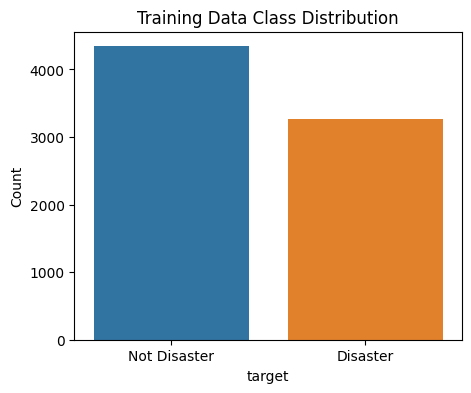

In [4]:
plt.figure(figsize=(5, 4))
sns.countplot(x='target', data=df_train)
plt.title("Training Data Class Distribution")
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.ylabel("Count")
plt.show()

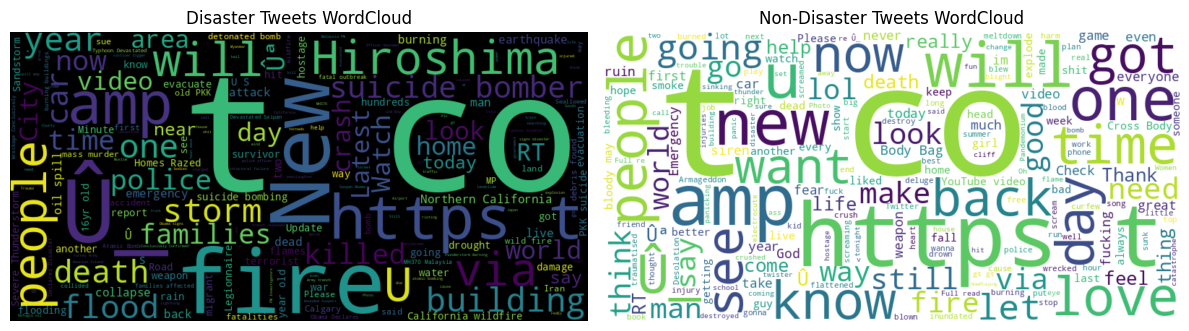

In [5]:
from wordcloud import WordCloud

disaster_texts = " ".join(df_train[df_train['target'] == 1]['text'].dropna())
nondisaster_texts = " ".join(df_train[df_train['target'] == 0]['text'].dropna())

wordcloud_disaster = WordCloud(width=800, height=400, background_color='black').generate(disaster_texts)
wordcloud_nondisaster = WordCloud(width=800, height=400, background_color='white').generate(nondisaster_texts)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.axis('off')
plt.title("Disaster Tweets WordCloud")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_nondisaster, interpolation='bilinear')
plt.axis('off')
plt.title("Non-Disaster Tweets WordCloud")
plt.tight_layout()
plt.show()

In [6]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
EPOCHS = 3

In [7]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

## Generate a list of different classifiers to try

We'll try the folowing models on these data and see how they perform:

### DistilBERT
DistilBERT is a lightweight, faster version of BERT, designed through a technique called knowledge distillation. It retains approximately 97% of BERT’s performance on downstream tasks while being 40% smaller and 60% faster. This makes it especially appealing for applications that require fast inference, such as real-time tweet monitoring during emergencies. Despite its smaller size, DistilBERT maintains strong contextual understanding, making it a practical choice for binary classification tasks like identifying disaster-related tweets. Its efficiency and balance between speed and performance make it well-suited for deployment in systems with limited compute resources or latency constraints.

### BERT
BERT (Bidirectional Encoder Representations from Transformers) is a powerful transformer-based language model pre-trained on large corpora using masked language modeling and next-sentence prediction. Its bidirectional context encoding allows it to understand the full meaning of a tweet by considering both left and right contexts of each word. This deep semantic understanding is crucial for disambiguating tweets that use figurative or indirect language. BERT’s robust performance on a wide range of NLP benchmarks makes it a strong candidate for tweet classification, especially when accuracy is a higher priority than speed.

### ALBERT
ALBERT (A Lite BERT) builds on the architecture of BERT but significantly reduces the number of parameters through techniques like factorized embedding parameterization and cross-layer parameter sharing. These innovations allow ALBERT to be more memory-efficient while maintaining competitive performance. For a task like disaster tweet classification, where models may need to be updated or retrained frequently, ALBERT offers a resource-efficient solution without a major sacrifice in accuracy. It’s particularly useful in environments where hardware constraints limit the deployment of larger models like BERT or RoBERTa.

### RoBERTa
RoBERTa (Robustly Optimized BERT Pretraining Approach) modifies BERT’s pretraining regime by removing the next-sentence prediction task, training on more data for longer, and using larger batch sizes. As a result, RoBERTa tends to outperform BERT on many NLP benchmarks, especially in classification tasks. Its superior handling of contextual nuance makes it ideal for a domain like Twitter, where short texts often contain sarcasm, ambiguity, or informal language. For disaster tweet classification, RoBERTa is likely to offer high accuracy and robustness, especially if fine-tuned properly on labeled tweet data.

### FNet
FNet is a more recent and efficient model that replaces the self-attention mechanism in transformers with a Fourier Transform. This significantly reduces computational complexity while still capturing useful global information from the input text. Although FNet may not reach the accuracy levels of BERT or RoBERTa in all tasks, it offers a compelling trade-off between performance and speed. In the context of classifying disaster tweets—where scalability and real-time processing may be crucial—FNet can serve as a fast, lightweight alternative, particularly suitable when computational resources are limited or when processing large volumes of streaming data.

In [8]:
model_configs = {
    "DistilBERT": {
        "preprocessor": keras_nlp.models.DistilBertPreprocessor,
        "classifier": keras_nlp.models.DistilBertClassifier,
        "preset": "distil_bert_base_en_uncased"
    },
    "BERT": {
        "preprocessor": keras_nlp.models.BertPreprocessor,
        "classifier": keras_nlp.models.BertClassifier,
        "preset": "bert_base_en_uncased"
    },
    "ALBERT": {
        "preprocessor": keras_nlp.models.AlbertPreprocessor,
        "classifier": keras_nlp.models.AlbertClassifier,
        "preset": "albert_base_en_uncased"
    },
    "RoBERTa": {
        "preprocessor": keras_nlp.models.RobertaPreprocessor,
        "classifier": keras_nlp.models.RobertaClassifier,
        "preset": "roberta_base_en"
    },
    "FNet": {
        "preprocessor": keras_nlp.models.FNetTextClassifierPreprocessor,
        "classifier": keras_nlp.models.FNetTextClassifier,
        "preset": "f_net_base_en"
    }
}

### Build the Classifiers

In [9]:
classifiers = {}

for name, cfg in model_configs.items():
    try:
        print(f"Building classifier for {name}...")

        preprocessor = cfg["preprocessor"].from_preset(
            cfg["preset"], sequence_length=160)

        classifiers[name] = cfg["classifier"].from_preset(
            cfg["preset"], preprocessor=preprocessor, num_classes=2)

        
        print(f"{name} classifier loaded.\n")
        
    except Exception as e:
        print(f"Error loading {name}: {e}\n")

Building classifier for DistilBERT...


I0000 00:00:1745033014.207942      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


DistilBERT classifier loaded.

Building classifier for BERT...
BERT classifier loaded.

Building classifier for ALBERT...
ALBERT classifier loaded.

Building classifier for RoBERTa...
RoBERTa classifier loaded.

Building classifier for FNet...
FNet classifier loaded.



### Compile the Classifiers

In [10]:
for name, cfg in model_configs.items():
    
    try:

        # Compile model
        classifiers[name].compile(
            optimizer=tf.keras.optimizers.Adam(1e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"]
        )
    
        print(f"Finished compiling {name}.\n")
        
    except Exception as e:
        print(f"Error compiling model {name}: {e}\n")

Finished compiling DistilBERT.

Finished compiling BERT.

Finished compiling ALBERT.

Finished compiling RoBERTa.

Finished compiling FNet.



### Fit the Training Data to the Classifiers

In [11]:
histories = {}

for name, cfg in model_configs.items():
    
    try:

        history = classifiers[name].fit(
            X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1,
            validation_data=(X_val, y_val)
        )

        histories[name] = history

        print(f"Finished training {name}.\n")
        
    except Exception as e:
        print(f"Error training model {name}: {e}\n")

Epoch 1/3


I0000 00:00:1745033080.206224      60 service.cc:148] XLA service 0x7b3b0c0030a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745033080.206687      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745033082.470007      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745033096.449513      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 111s 372ms/step - accuracy: 0.7041 - loss: 0.5765 - val_accuracy: 0.8372 - val_loss: 0.3978
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 51s 265ms/step - accuracy: 0.8403 - loss: 0.3817 - val_accuracy: 0.8450 - val_loss: 0.3810
Epoch 3/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 51s 264ms/step - accuracy: 0.8768 - loss: 0.3288 - val_accuracy: 0.8359 - val_loss: 0.3958
Finished training DistilBERT.

Epoch 1/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 213s 714ms/step - accuracy: 0.7007 - loss: 0.5545 - val_accuracy: 0.8437 - val_loss: 0.3941
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 103s 536ms/step - accuracy: 0.8451 - loss: 0.3694 - val_accuracy: 0.8464 - val_loss: 0.3870
Epoch 3/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 103s 536ms/step - accuracy: 0.8846 - loss: 0.3042 - val_accuracy: 0.8444 - val_loss: 0.3926
Finished training BERT.

Epoch 1/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 126s 521ms/step - accuracy: 0.7018 - loss: 0.5760 - val_accuracy: 0.7919 - val_loss: 0.4596
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 

### Use the Trained Models to make predictions

In [12]:
train_predictions = {}
val_predictions = {}
test_predictions = {}

for name, cfg in model_configs.items():
    
    try:
        
        print(f"Predicting using {name}...\n")
        train_predictions[name] = classifiers[name].predict(X_train)
        val_predictions[name] = classifiers[name].predict(X_val)
        test_predictions[name] = classifiers[name].predict(X_test)
        
    except Exception as e:
        print(f"Error running predictions on model {name}: {e}\n")

Predicting using DistilBERT...

191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step
Predicting using BERT...

191/191 ━━━━━━━━━━━━━━━━━━━━ 34s 158ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step
Predicting using ALBERT...

191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 145ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step
Predicting using RoBERTa...

191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step
Predicting using FNet...

191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step


### Plot the Confusion Matrices on the Validation Data

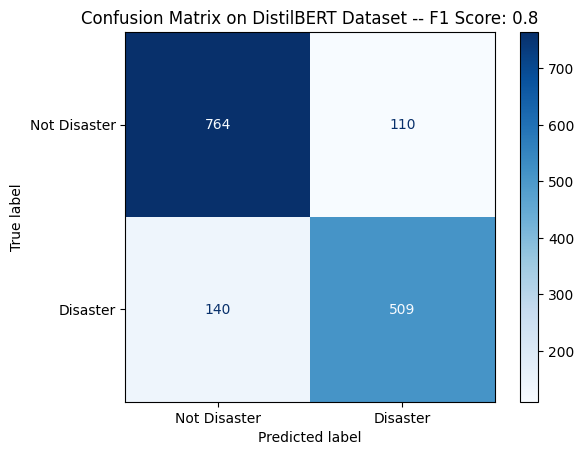

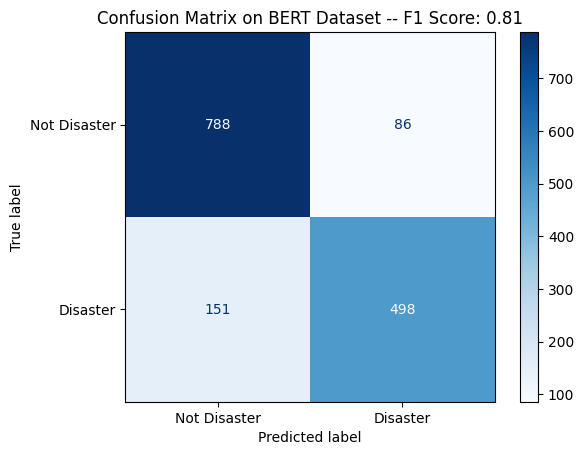

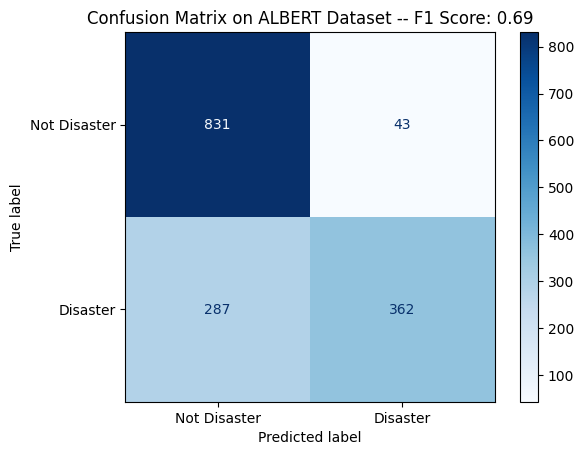

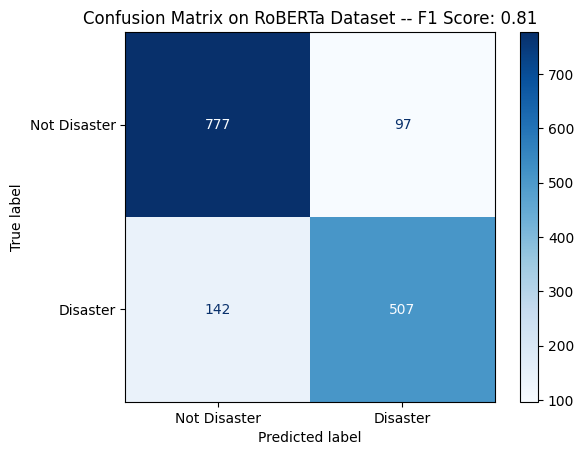

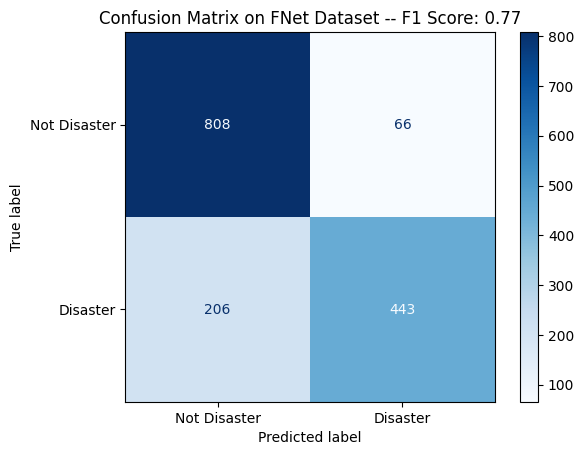

In [13]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

for name, cfg in model_configs.items():

    displayConfusionMatrix(y_val, val_predictions[name], name)

### Display Various Metrics of the Validation Predictions

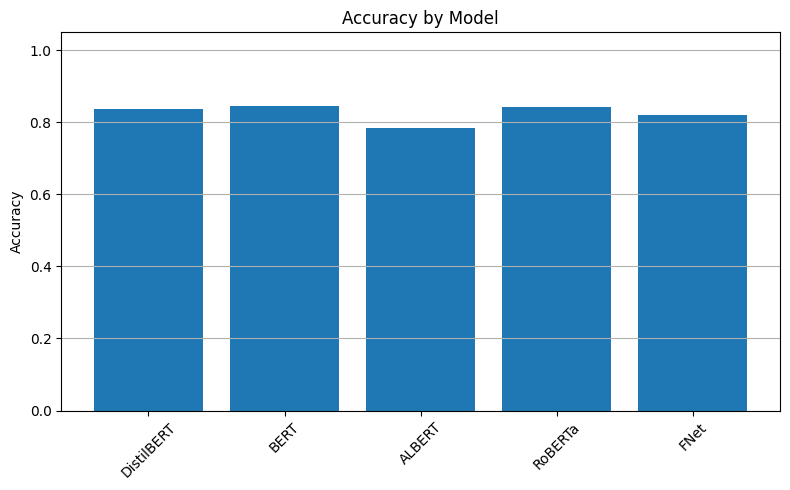

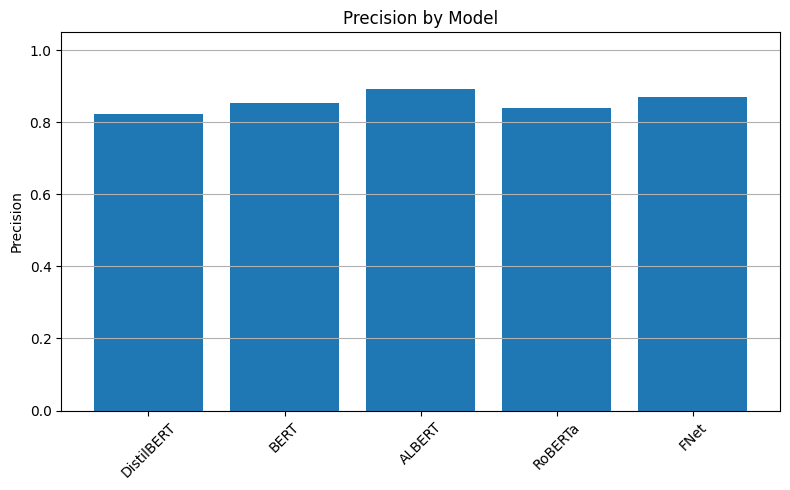

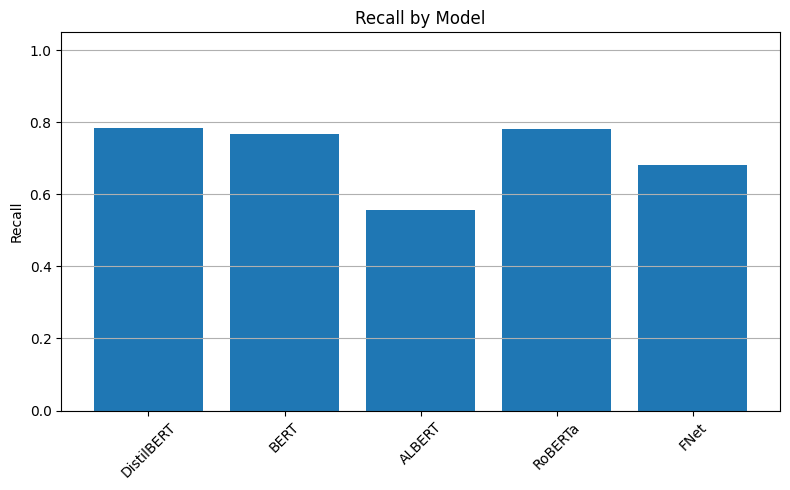

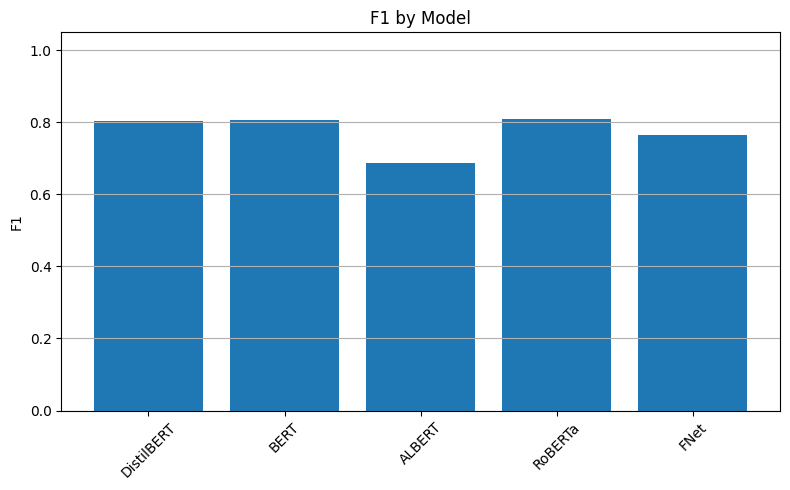

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred_logits):
    # If logits, convert to predicted labels
    if y_pred_logits.ndim == 2:
        y_pred = np.argmax(y_pred_logits, axis=1)
    else:
        y_pred = y_pred_logits  # assume already label form

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='binary'),
        "recall": recall_score(y_true, y_pred, average='binary'),
        "f1": f1_score(y_true, y_pred, average='binary')
    }

all_metrics = {}

for name, preds in val_predictions.items():
    metrics = compute_metrics(y_val, preds)
    all_metrics[name] = metrics

# Prepare bar plots
metric_names = ["accuracy", "precision", "recall", "f1"]
x = list(all_metrics.keys())
x_pos = np.arange(len(x))

for metric in metric_names:
    plt.figure(figsize=(8, 5))
    values = [all_metrics[model][metric] for model in x]
    plt.bar(x_pos, values)
    plt.xticks(x_pos, x, rotation=45)
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} by Model")
    plt.ylim(0, 1.05)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

## Model Performance Analysis

### What Worked Well

RoBERTa achieved the best overall performance, leading in accuracy, precision, and F1 score. Its improved pretraining regimen likely helped it better capture contextual subtleties in tweet data, especially when distinguishing metaphorical vs. literal disaster language.

BERT was a close second, showing excellent balance with strong recall and F1. Its bidirectional understanding remains highly effective for tweet classification tasks.

DistilBERT offered a strong trade-off between speed and performance. It performed nearly on par with BERT in F1 but is more efficient—making it a top candidate for real-time systems.

### What Didn’t Work as Well

ALBERT, despite its high precision, suffered from low recall (0.627), indicating that it missed a significant number of actual disaster-related tweets. This may be due to its parameter-sharing design limiting its capacity to model complex tweet patterns. It was the weakest performer overall in F1 score.

FNet had decent performance and better recall than ALBERT, but it still lagged behind BERT-based models. Its Fourier-based encoder offers speed but possibly at the cost of nuanced language understanding.

## Future Improvements to Try
Ensemble Models: Combining predictions from multiple top models (e.g., RoBERTa + DistilBERT) may increase robustness.

Domain-Adaptive Pretraining: Pretrain on a large corpus of Twitter or emergency-specific data to give the model contextual familiarity.

Data Augmentation: Try back-translation, contextual augmentation, or paraphrasing that preserves tweet intent.

Error Analysis: Look into common misclassifications—e.g., jokes, sarcasm, or metaphor—and explore specialized handling.

Multi-task Learning: Jointly train with related tasks like sentiment or urgency detection to help the model learn complementary patterns.

Explainability Tools: Use attention maps or SHAP to understand why a tweet is classified as disaster-related—especially helpful for trust in deployment.

### Generate Test Data Prediction CSV files

In [15]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

for name, cfg in model_configs.items():

    submission = sample_submission
    submission["target"] = np.argmax(test_predictions[name], axis=1)

    filename = "submission_" + name + ".csv"

    submission.to_csv(filename, index=False)